# Planar Maximally Filtered Graph (PMFG)

M. Tumminello (2005)

## Import modules

In [1]:
import matplotlib.pyplot as plt
import networkx as nx

# import custom functions
from corrmat_functions import *
from plot_utils import *

## Import denoised not null correlation matrices

In [2]:
denoised_notnull_corrmats = np.load('data/denoised_notnull_corrmats.npy', allow_pickle=True).item()

## Construction of PMFG networks

source: https://gmarti.gitlab.io/networks/2018/06/03/pmfg-algorithm.html
corrected descending order of edges

In [3]:
def compute_complete_graph(*, corr, tics):
    nb_nodes = len(corr)
    complete_graph = nx.Graph()
    for i in range(nb_nodes):
        for j in range(i+1, nb_nodes):
            complete_graph.add_edge(i if tics is None else tics[i], j if tics is None else tics[j], weight=corr[i,j])
    return complete_graph
    
def sort_graph_edges(*, graph):
    sorted_edges = []
    for source, dest, data in sorted(graph.edges(data=True), key=lambda x: x[2]['weight'], reverse=True):
        sorted_edges.append({'source': source,
                             'dest': dest,
                             'weight': data['weight']})
        
    return sorted_edges

def compute_PMFG(*, sorted_edges, number_of_nodes):
    PMFG = nx.Graph()
    for edge in sorted_edges:
        PMFG.add_edge(edge['source'], edge['dest'])
        PMFG[edge['source']][edge['dest']]['weight'] = edge['weight']
        if not nx.algorithms.planarity.check_planarity(PMFG)[0]:
            PMFG.remove_edge(edge['source'], edge['dest'])
            
        if len(PMFG.edges()) == 3*(number_of_nodes-2):
            break
    return PMFG

def get_pmfg(*, corr, tics=None):
    complete_graph = compute_complete_graph(corr=corr, tics=tics)
    sorted_edges = sort_graph_edges(graph=complete_graph)
    PMFG = compute_PMFG(sorted_edges=sorted_edges, number_of_nodes=len(complete_graph.nodes))
    return PMFG



## Compute and save PMFG networks

In [4]:
pmfg_networks = {} # instantiate a dict for pmfg networks
for k, v in denoised_notnull_corrmats.items():
    corr = v['corrmat']
    tics = v['tickers']
    pmfg_networks[k] = {'network' : get_pmfg(corr=corr, tics=None),\
                        'ticker' : tics}
    
#saving pmfg network dictionaries to file
np.save('data/pmfgs.npy', pmfg_networks)

## Sample plot of PMFG

126 edges instead of 946


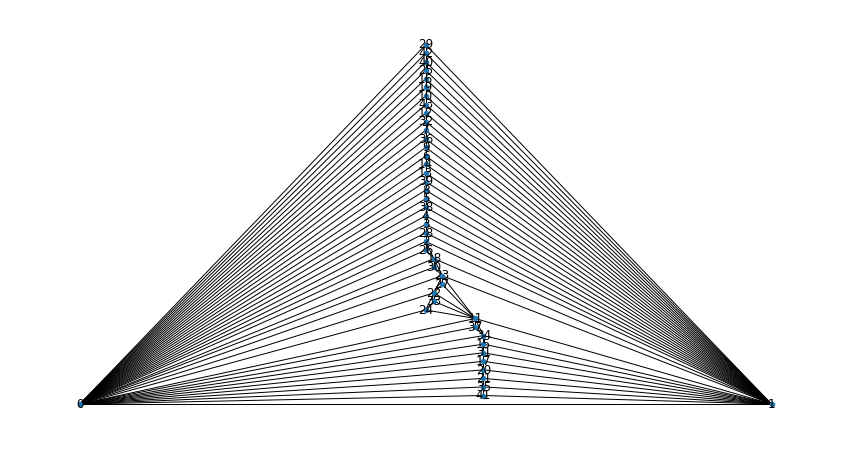

In [5]:
k = list(denoised_notnull_corrmats.keys())[0]

corr = denoised_notnull_corrmats[k]['corrmat']
tics = denoised_notnull_corrmats[k]['tickers']

nb_nodes = len(corr)
PMFG = get_pmfg(corr=corr, tics=None)
print(len(PMFG.edges), "edges instead of", int(nb_nodes*(nb_nodes-1)/2))

fig, ax = plt.subplots(figsize=(15, 8), facecolor='0.9')    
nx.draw_planar(PMFG, with_labels=True, node_size=20, ax=ax)
plt.show()


In [6]:
def test_plots(*, denoised_notnull_corrmats, number_of_plots=10, layout='planar'):
    k_list = list(denoised_notnull_corrmats.keys())
    for index, k in enumerate(k_list):
        if index >= number_of_plots:
            break
        
        corr = denoised_notnull_corrmats[k]['corrmat']
        tics = denoised_notnull_corrmats[k]['tickers']

        PMFG = get_pmfg(corr=corr, tics=None)

        plot_network(graph=PMFG, tics=tics, layout=layout, title=f'PMFG at {k}',\
                     min_node_degree_to_show_label=4, top_perc_to_show_label=0.15)


            
test_plots(denoised_notnull_corrmats=denoised_notnull_corrmats, number_of_plots=5, layout='planar')
test_plots(denoised_notnull_corrmats=denoised_notnull_corrmats, number_of_plots=5, layout='circular')